# Project 2024

This notebook shows you how to load data into R and proposes some regression models that could be (but don't have to be) used as a starting point.  As we aim to model the number of protests, we need to consider statistical models that deal with counts data.  Such models are not (to my knowledge) taught in our undergrad courses.

This dataset was downloaded from the he Armed Conflict Location & Event Data Project (ACLED) while the population values were downloaded from Statistics Canada.

In [3]:
# Use read.csv to load the data into R
dat = read.csv("canadianProtestData.csv")
head(dat)

# Tell R that province and month are factors (see stat 368 for more)
dat$prov  <- as.factor( dat$prov  )
dat$month <- as.factor( dat$month )

dat$year <- as.factor( dat$year )

# Tell R that these are ... numbers?!?
dat$pop <- as.numeric( dat$pop )
dat$protests <- as.numeric( dat$protests )

# Look at the data!
print(paste("This dataset has", nrow(dat), "entries"))
head(dat)
dat$prov[1:6]

,X,year,month,prov,pop,protests
,<int>,<int>,<chr>,<chr>,<int>,<int>
1,1,2023,November,Alberta,4756408,20
2,2,2023,November,British Columbia,5581127,27
3,3,2023,November,Manitoba,1465440,10
4,4,2023,November,New Brunswick,842725,5
5,5,2023,November,Newfoundland and Labrador,540418,7
6,6,2023,November,Northwest Territories,44760,2


[1] "This dataset has 299 entries"


,X,year,month,prov,pop,protests
,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,1,2023,November,Alberta,4756408,20
2,2,2023,November,British Columbia,5581127,27
3,3,2023,November,Manitoba,1465440,10
4,4,2023,November,New Brunswick,842725,5
5,5,2023,November,Newfoundland and Labrador,540418,7
6,6,2023,November,Northwest Territories,44760,2


[1] Alberta                   British Columbia         
[3] Manitoba                  New Brunswick            
[5] Newfoundland and Labrador Northwest Territories    
13 Levels: Alberta British Columbia Manitoba ... Yukon

## Classic Poisson Regression

Recall that if $Z\sim\mathrm{Poisson}(\lambda)$ then $\mathrm{E}Z = \lambda$ and $\mathrm{Var}(Z) = \lambda$.  This makes Poisson regression actually quite rigid.  
 This is a statistical model that says in the context of this data that
$$
  \mathrm{E}(\mathrm{protests}) = g^{-1}(
    \beta_0 + \beta_1 (\mathrm{year}) + \beta_2 (\mathrm{month}) + \beta_3 (\mathrm{prov}) + \beta_4 (\mathrm{pop})
  )
$$
where $g$ is a "link" function that can be selected by the user.  In R's `glm` code, you can choose $g$ to be the log, square root, or identity function.

In [15]:
# Classic Poisson Regression with a log-link function
md.1 <- glm( protests~year+month+prov+pop, data=dat, family=poisson(link = "log") )
# summary(md.1)

# or with log population as a predictor?
md.1a <- glm( protests~year+month+prov+log10(pop), data=dat, family=poisson(link = "log") )
# summary(md.1a)


[1] 0.866007


## Overdispersed Poisson Regression
To account for the rigidity of the Poisson distribution, we could choose to include a "dispersion" parameter $\phi>0$.  Then, our random variable $Z$ will have 
$\mathrm{E}Z = \lambda$ as before but with $\mathrm{Var}(Z) = \phi\lambda$.  This will complicate things like simulating overdispersed Poisson data!

In [5]:
# Overdispersed Poisson Regression with a log-link function
md.2 <- glm( protests~year+month+prov+pop, data=dat, family=quasipoisson(link = "log") )
summary(md.2)

md.2a <- glm( protests~year+month+prov+log10(pop), data=dat, family=quasipoisson(link = "log") )
summary(md.2a)


Call:
glm(formula = protests ~ year + month + prov + pop, family = quasipoisson(link = "log"), 
    data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2822  -1.1722  -0.2608   0.8160   4.7145  

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -8.360e-02  1.195e+00  -0.070 0.944279    
year2023                      -1.230e-01  7.980e-02  -1.541 0.124474    
monthAugust                   -7.014e-01  1.372e-01  -5.113 5.97e-07 ***
monthDecember                 -6.351e-01  1.741e-01  -3.648 0.000317 ***
monthFebruary                  6.472e-02  1.116e-01   0.580 0.562334    
monthJanuary                  -3.420e-01  1.244e-01  -2.749 0.006383 ** 
monthJuly                     -5.842e-01  1.322e-01  -4.420 1.42e-05 ***
monthJune                     -3.306e-01  1.229e-01  -2.691 0.007569 ** 
monthMarch                    -9.072e-02  1.160e-01  -0.782 0.435009    
monthMay                    


Call:
glm(formula = protests ~ year + month + prov + log10(pop), family = quasipoisson(link = "log"), 
    data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2533  -1.2326  -0.2597   0.7165   5.1320  

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -177.86192  115.63769  -1.538 0.125183    
year2023                        -0.29868    0.21356  -1.399 0.163083    
monthAugust                     -0.75206    0.14996  -5.015 9.55e-07 ***
monthDecember                   -0.73557    0.20859  -3.526 0.000494 ***
monthFebruary                    0.09703    0.11775   0.824 0.410659    
monthJanuary                    -0.30972    0.13027  -2.378 0.018118 *  
monthJuly                       -0.63486    0.14528  -4.370 1.77e-05 ***
monthJune                       -0.33059    0.12423  -2.661 0.008248 ** 
monthMarch                      -0.05841    0.12209  -0.478 0.632734    
monthMay             

## Ridge and Lasso
Or we could try a Poisson regression with a ridge or lasso or elastic net penalty.  If only there were a good way to pick the tuning parameter...

In [6]:
install.package("glmnet") # install a package for use later

ERROR: Error in install.package("glmnet"): could not find function "install.package"


In [ ]:
library(glmnet) # load in an installed package

Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.3.2”
Loaded glmnet 4.1-8



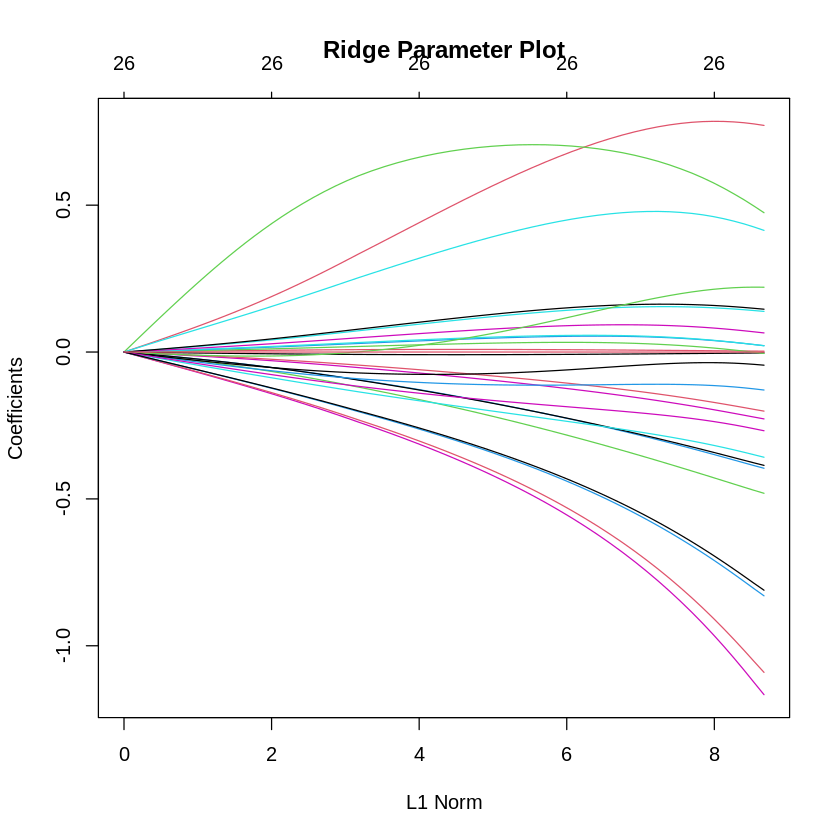

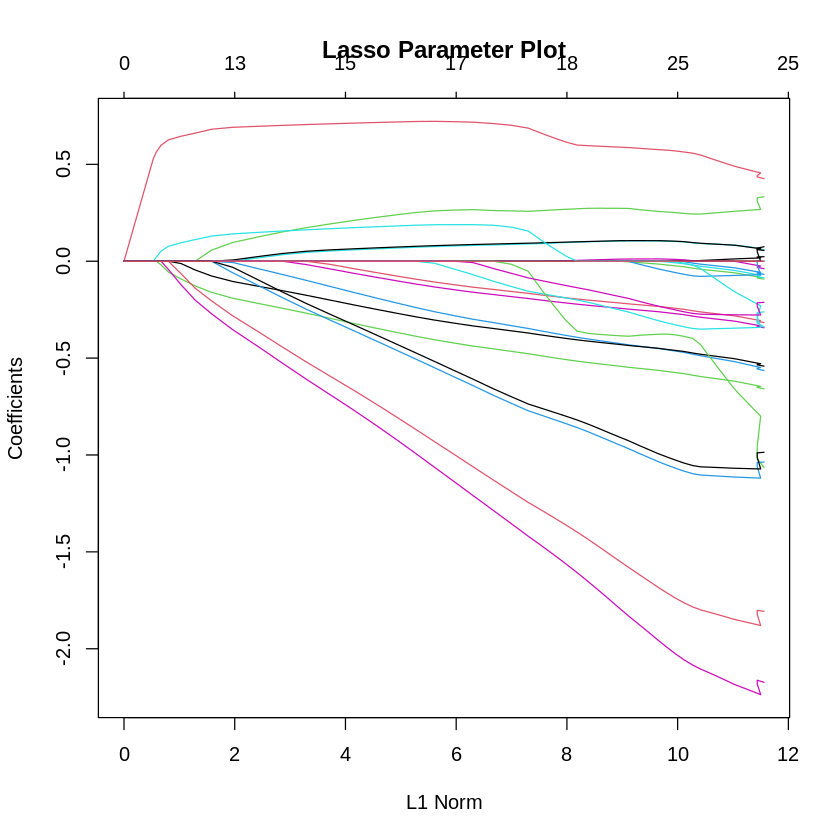

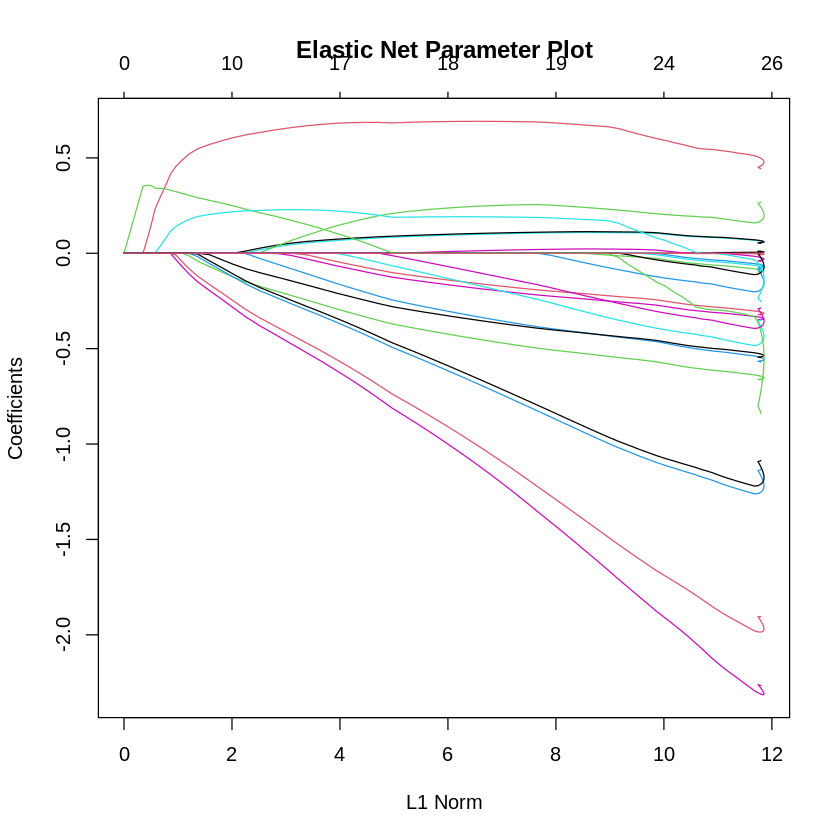

In [ ]:
# glmnet doesn't know how to handle factor variables, so we have to make a big model matrix
dat.modmat <- model.matrix( ~ .-1, dat[,2:5])

md.ridge <- glmnet(x = dat.modmat,y=dat[,6],family = "poisson",alpha = 0)
md.lasso <- glmnet(x = dat.modmat,y=dat[,6],family = "poisson",alpha = 1)
md.elnet <- glmnet(x = dat.modmat,y=dat[,6],family = "poisson",alpha = 1/4) # or otherwise
plot(md.ridge,main="Ridge Parameter Plot")
plot(md.lasso,main="Lasso Parameter Plot")
plot(md.elnet,main="Elastic Net Parameter Plot")


In [ ]:
# this is a form of variable selection for choosing a model
# as lambda gets smaller, more variables are included in the model

signif(rbind(
  md.lasso$beta[,c(1,10,20,30,40,50)],
  lamb = md.lasso$lambda[c(1,10,20,30,40,50)]
),4)


27 x 6 sparse Matrix of class "dgCMatrix"
                                 s0        s9       s19        s29        s39
year2022                       .    .         .          .          .        
year2023                       .    .         .          .          .        
monthAugust                    .    .         .         -1.606e-01 -4.052e-01
monthDecember                  .    .         .          .         -2.604e-01
monthFebruary                  .    .         .          .          7.558e-02
monthJanuary                   .    .         .          .         -1.327e-01
monthJuly                      .    .         .         -7.624e-02 -3.036e-01
monthJune                      .    .         .          .         -1.073e-01
monthMarch                     .    .         .          .          .        
monthMay                       .    .         .          .          .        
monthNovember                  .    .         .          .          .        
monthOctober          

## Negative Binomial Distribution

Or we could be fancier an try a different distribution called the negative binomial. https://en.wikipedia.org/wiki/Negative_binomial_distribution
This is a generalization of the geometric distribution and can also be thought of as a mixture of Poisson distributions.  

In [ ]:
# Need this for the negative binomial regression
library(MASS)

In [ ]:
# Negative Binomial Regression in R
md.3 <- glm.nb( protests~year+month+prov+pop, data=dat )
summary(md.3)

# Or leave out population
md.3a <- glm.nb( protests~year+month+prov, data=dat )
summary(md.3a)

# Or leave out province
md.3b <- glm.nb( protests~year+month+pop, data=dat )
summary(md.3b)


Call:
glm.nb(formula = protests ~ year + month + prov + pop, data = dat, 
    init.theta = 10.03854255, link = log)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    1.192e+00  1.568e+00   0.760 0.447361    
year2023                      -3.366e-02  7.768e-02  -0.433 0.664777    
monthAugust                   -7.374e-01  1.463e-01  -5.041 4.63e-07 ***
monthDecember                 -6.554e-01  1.845e-01  -3.552 0.000382 ***
monthFebruary                  7.490e-02  1.317e-01   0.569 0.569689    
monthJanuary                  -3.036e-01  1.375e-01  -2.208 0.027239 *  
monthJuly                     -5.831e-01  1.430e-01  -4.079 4.52e-05 ***
monthJune                     -3.911e-01  1.387e-01  -2.820 0.004798 ** 
monthMarch                    -7.516e-02  1.338e-01  -0.562 0.574448    
monthMay                      -5.160e-02  1.332e-01  -0.387 0.698445    
monthNovember                 -1.420e-01  1.381e-01  -1.028 0.303


Call:
glm.nb(formula = protests ~ year + month + prov, data = dat, 
    init.theta = 9.798091084, link = log)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    2.8039027  0.1289376  21.746  < 2e-16 ***
year2023                       0.0193431  0.0592407   0.327 0.744033    
monthAugust                   -0.7183787  0.1463625  -4.908 9.19e-07 ***
monthDecember                 -0.6271595  0.1837210  -3.414 0.000641 ***
monthFebruary                  0.0672649  0.1326218   0.507 0.612019    
monthJanuary                  -0.3118493  0.1383349  -2.254 0.024177 *  
monthJuly                     -0.5665769  0.1431010  -3.959 7.52e-05 ***
monthJune                     -0.3903432  0.1397160  -2.794 0.005209 ** 
monthMarch                    -0.0812603  0.1346837  -0.603 0.546281    
monthMay                      -0.0517293  0.1342567  -0.385 0.700014    
monthNovember                 -0.1081907  0.1350808  -0.801 0.423170   


Call:
glm.nb(formula = protests ~ year + month + pop, data = dat, init.theta = 1.945410477, 
    link = log)

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     1.572e+00  1.689e-01   9.304  < 2e-16 ***
year2023       -1.735e-02  9.738e-02  -0.178  0.85858    
monthAugust    -7.202e-01  2.344e-01  -3.073  0.00212 ** 
monthDecember  -6.785e-01  2.939e-01  -2.309  0.02096 *  
monthFebruary   6.695e-02  2.228e-01   0.301  0.76379    
monthJanuary   -2.678e-01  2.268e-01  -1.180  0.23781    
monthJuly      -5.503e-01  2.312e-01  -2.380  0.01731 *  
monthJune      -4.002e-01  2.288e-01  -1.749  0.08026 .  
monthMarch     -7.489e-02  2.244e-01  -0.334  0.73853    
monthMay       -5.970e-02  2.242e-01  -0.266  0.78999    
monthNovember  -1.818e-01  2.256e-01  -0.806  0.42025    
monthOctober   -1.286e-02  2.236e-01  -0.058  0.95414    
monthSeptember  1.043e-01  2.224e-01   0.469  0.63910    
pop             2.132e-07  1.008e-08  21.146  < 2e-16 ***
---
S

# Zero-Inflated Model
Noting that there are a lot of zeros in this dataset, i.e. 45/299 = 15%, we may wish to try a zero-inflated model.  These models have two steps to them.  First they use a logistic regression to determine whether or not an entry will be zero.  If the prediction is non-zero, then it uses a Poisson or negative binomial regression to determine the predicted value.

[1] "There are 45 zeros in the dataset!"


Group.1,x
<fct>,<int>
Alberta,0
British Columbia,0
Manitoba,0
New Brunswick,1
Newfoundland and Labrador,1
Northwest Territories,15
Nova Scotia,1
Nunavut,12
Ontario,0


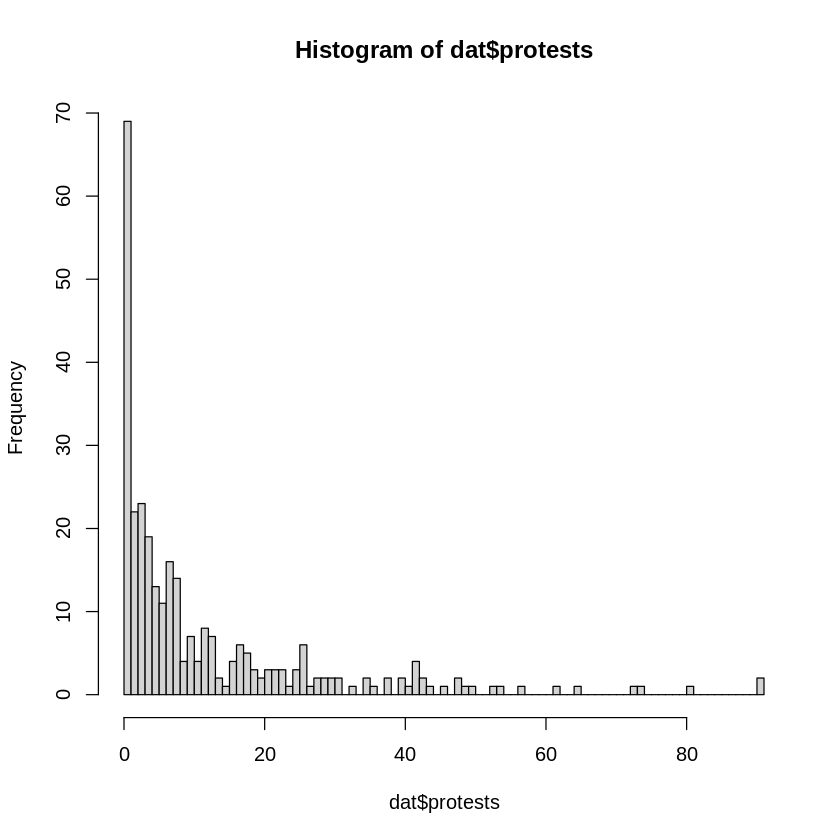

In [ ]:
hist(dat$protests,breaks=100)
print(paste("There are",sum(dat$protests==0),"zeros in the dataset!"))
aggregate( dat$protests==0, list(dat$prov), FUN=sum) 

In [ ]:
# need some extra packages for this!
install.packages("pscl")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [ ]:
# Load in the package
library("pscl")

Classes and Methods for R originally developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University (2002-2015),
by and under the direction of Simon Jackman.
hurdle and zeroinfl functions by Achim Zeileis.



In [ ]:
# Zero inflated Poisson
md.4 <- zeroinfl( protests~year+month | log10(pop), data=dat, dist="poisson" )
summary(md.4)


Call:
zeroinfl(formula = protests ~ year + month | log10(pop), data = dat, 
    dist = "poisson")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-3.0534 -1.5434 -0.8683  0.2453 19.0421 

Count model coefficients (poisson with log link):
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.77908    0.05526  50.294  < 2e-16 ***
year2023        0.01235    0.03396   0.364 0.715974    
monthAugust    -0.51845    0.08873  -5.843 5.13e-09 ***
monthDecember  -0.31288    0.11175  -2.800 0.005114 ** 
monthFebruary  -0.04033    0.07253  -0.556 0.578174    
monthJanuary   -0.27209    0.08102  -3.358 0.000784 ***
monthJuly      -0.40113    0.08541  -4.697 2.65e-06 ***
monthJune      -0.23911    0.08009  -2.986 0.002831 ** 
monthMarch     -0.11290    0.07541  -1.497 0.134341    
monthMay       -0.07986    0.07481  -1.068 0.285731    
monthNovember  -0.10878    0.07448  -1.461 0.144149    
monthOctober   -0.01787    0.07363  -0.243 0.808240    
monthSeptember  0.10

In [ ]:
# Zero inflated negative binomial
md.5 <- zeroinfl( protests~year+month | log10(pop), data=dat, dist="negbin" )
summary(md.5)


Call:
zeroinfl(formula = protests ~ year + month | log10(pop), data = dat, 
    dist = "negbin")

Pearson residuals:
     Min       1Q   Median       3Q      Max 
-0.92350 -0.57684 -0.40056  0.08322  4.58710 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.751920   0.237153  11.604   <2e-16 ***
year2023        0.020903   0.138530   0.151   0.8801    
monthAugust    -0.567521   0.325447  -1.744   0.0812 .  
monthDecember  -0.402754   0.419944  -0.959   0.3375    
monthFebruary  -0.016839   0.310391  -0.054   0.9567    
monthJanuary   -0.283931   0.323666  -0.877   0.3804    
monthJuly      -0.444443   0.326332  -1.362   0.1732    
monthJune      -0.252550   0.322172  -0.784   0.4331    
monthMarch     -0.111137   0.315439  -0.352   0.7246    
monthMay       -0.100384   0.312771  -0.321   0.7482    
monthNovember  -0.092902   0.311525  -0.298   0.7655    
monthOctober   -0.006371   0.314367  -0.020   0.9838    